In [5]:
import timm
import torch

In [46]:
from collections import defaultdict

def get_layer(model, layer_name: str):
    layers = layer_name.split('.')
    for layer in layers:
        if layer.isnumeric():
            model = model[int(layer)]
        elif hasattr(model, layer):
            model = getattr(model, layer)
        else:
            raise ValueError(f"Layer {layer} not found in {model}")
    return model

def clean_tensor(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu()
    elif isinstance(tensor, tuple):
        return tuple(clean_tensor(t) for t in tensor)
    elif isinstance(tensor, list):
        return [clean_tensor(t) for t in tensor]
    elif isinstance(tensor, dict):
        return {k: clean_tensor(v) for k, v in tensor.items()}
    else:
        return tensor

class ActivationCache(object):
    def __init__(self):
        self.cache = defaultdict(dict)  
        self.hooks = {}
        
    def clear(self):
        self.cache = {}

    def _hook_fn(self, layer_name: str):
        def hook_fn(module, input, output):
            self.cache[layer_name]["input"] = clean_tensor(input)
            self.cache[layer_name]["output"] = clean_tensor(output)
        return hook_fn


    def hook_layer(self, model, layer_name: str):
        layer = get_layer(model, layer_name)
        # print(f"Hooking {layer_name}")
        hook = layer.register_forward_hook(self._hook_fn(layer_name))
        return hook
        
    def hook(self, model: timm.models.vision_transformer.VisionTransformer):
        # get Attention params: H, D
        self.H = model.blocks[0].attn.num_heads
        self.D = model.blocks[0].attn.proj.weight.shape[0] # (D, D)


        # hook the layers
        self.n_blocks = len(model.blocks)
        for i in range(self.n_blocks):
            # deactivate fused_attn to get access to the individual components
            model.blocks[i].attn.fused_attn = False
            for layer_name in self._hooked_layers_per_block(i):
                self.hooks[layer_name] = self.hook_layer(model, layer_name)
        
        # self.hooks[''] = model.register_forward_hook(self._hook_fn(''))

    def get_attn_ft(self, block_idx: int):
        proj_input = self.cache[f'blocks.{block_idx}.attn.proj']['input'][0]
        B, N, _ = proj_input.shape

        # attn_ft: B, H, N, C//H
        # proj_input = attn_ft.transpose(1, 2).reshape(B, N, C)
        # reverse operation
        attn_ft = proj_input.reshape(B, N, self.H, self.D//self.H).transpose(1, 2)
        return attn_ft
    
    def get_attn(self, block_idx: int):
        return self.cache[f'blocks.{block_idx}.attn.attn_drop']['output']
    
    def get_zs(self):
        # zs: 0 = input of first block, same as input of first norm1
        # zs: i = input of norm2 of block i // 2 + 1
        # zs: i+1 = output of block i // 2 + 2, same as input of norm1 of the next block :0
        # zs: n = output of head, same as output of model
        zs = []
        zs.append(self.cache['blocks.0']['input'][0])
        for idx in range(self.n_blocks):
            """
            class Block:
                def forward(self, x: torch.Tensor) -> torch.Tensor:
                    x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
                    ---> hook on this x
                    x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x)))) 
                    ---> hook on this x
                    return x
            """
            z1 = self.cache[f'blocks.{idx}.norm2']['input'][0]
            # zs.append(self.cache[f'blocks.{idx}']['output'])
            #   This works too for standard timm ViTs, 
            #   but not for custom Blocks that output multiple tensors,
            #   like the cl_vs_mim ViT
            mlp_output = self.cache[f'blocks.{idx}.mlp']['output']
            z2 = mlp_output + z1
            zs.extend([z1, z2])
            

        # TODO: careful, this could change depending on the model
        # zs.append(self.cache['']['output'])
        zs.append(self.cache['head']['output'])
        return zs

    @staticmethod
    def _hooked_layers_per_block(i):
        return [
            f'blocks.{i}', # input -> zs[0]
            f'blocks.{i}.norm2',  # input -> zs[i]
            f'blocks.{i}.mlp', # output + zs[i] -> zs[i+1]
            f'blocks.{i}.attn.attn_drop' , # output -> attn
            f'blocks.{i}.attn.proj' , # input -> attn_ft
            f'head' , # output -> zs[-1]
        ]

    def unhook(self):
        for hook in self.hooks.values():
            hook.remove()
        self.hooks = {}



In [8]:
def load_part():
    from src.models.components.cl_vs_mim.vit import VisionTransformer
    from functools import partial
    from torch import nn as nn
    path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584_backbone.ckpt"  #@param {type:"string"}
    model = VisionTransformer(  
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6))

    model = model
    model = model.eval()
    out = model.load_state_dict(torch.load(path), strict=False)
    print(out)
    return model

part_1 = load_part()

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'head.weight', 'head.bias'], unexpected_keys=[])


In [248]:
part_3.pos_embed

In [249]:
from src.models.part_vit_module import PARTViTModule



path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584.ckpt"  #@param {type:"string"}
# reassign src.models.components.part_utils to src.models.components.utils.part_utils

import sys
sys.modules['src.models.components.part_utils'] = sys.modules['src.models.components.utils.part_utils']

part_3 = PARTViTModule.load_from_checkpoint(path, strict=False).net.backbone.cpu()
# add cls_token
part_3.cls_token = torch.nn.Parameter(torch.zeros(1, 1, 768))


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [250]:
path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584_backbone.ckpt"  #@param {type:"string"}
part_2 = timm.create_model('vit_base_patch16_224', pretrained=False).eval()
out = part_2.load_state_dict(torch.load(path), strict=False)
part_2.cls_token = part_3.cls_token
print(out)



_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'head.weight', 'head.bias'], unexpected_keys=[])


In [251]:
part_1.cls_token = part_3.cls_token

In [10]:
x  = torch.randn(1, 3, 224, 224)

In [253]:
# compare the two networks, part_1 and part_2

In [20]:
part_2_act = ActivationCache()
part_2.eval()
part_2_act.hook(part_2)

# rand seed 0
torch.manual_seed(0)
with torch.no_grad(), torch.inference_mode():
    part_2(x)

# get the activations

NameError: name 'part_2' is not defined

In [255]:
part_2.blocks[0].ls1

Identity()

In [47]:
part_1_act = ActivationCache()
part_1.eval()
part_1_act.hook(part_1)

# rand seed 0
torch.manual_seed(0)
with torch.no_grad(), torch.inference_mode():
    out, zs, attns, attn_fts = part_1(x)
# get the activations

In [57]:
print(len(attns), part_1_act.n_blocks)
for i in range(len(attns)):
    print(torch.allclose(attns[i], part_1_act.get_attn(i)))

12 12
True
True
True
True
True
True
True
True
True
True
True
True


In [56]:
print(len(attn_fts), part_1_act.n_blocks)
for i in range(len(attn_fts)):
    print(torch.allclose(attns[i], part_1_act.get_attn(i)))


12 12
True
True
True
True
True
True
True
True
True
True
True
True


In [52]:
print(part_1_act.get_zs()[0][0][0][:10])
print(zs[0][0][0][:10])

# torch.all_close
for i in range(len(zs)):
    zs_real = zs[i]
    zs_new = part_1_act.get_zs()[i]
    print(torch.allclose(zs_real, zs_new, atol=1e-6))

tensor([-0.0122,  0.0215, -0.0283,  0.0239,  0.0179,  0.0068,  0.0262,  0.0307,
         0.0213, -0.0361])
tensor([-0.0122,  0.0215, -0.0283,  0.0239,  0.0179,  0.0068,  0.0262,  0.0307,
         0.0213, -0.0361])
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [230]:
part_3_act = ActivationCache()
part_3.eval()
part_3_act.hook(part_3)

# rand seed 0
torch.manual_seed(0)
with torch.no_grad(), torch.inference_mode():
    part_3(x)

# get the activations

In [233]:
torch.manual_seed(0)
part_1.eval()
with torch.no_grad(), torch.inference_mode():
    out, zs, attns, attn_fts = part_1(x)

In [169]:
print(len(attns))
print(attns[0].shape)
print(attns[0][0][0][:10])

12
torch.Size([1, 12, 197, 197])
tensor([[0.0048, 0.0054, 0.0056,  ..., 0.0057, 0.0055, 0.0052],
        [0.0052, 0.0054, 0.0051,  ..., 0.0057, 0.0052, 0.0051],
        [0.0049, 0.0051, 0.0061,  ..., 0.0052, 0.0049, 0.0055],
        ...,
        [0.0047, 0.0057, 0.0052,  ..., 0.0056, 0.0055, 0.0054],
        [0.0050, 0.0047, 0.0056,  ..., 0.0050, 0.0048, 0.0056],
        [0.0054, 0.0051, 0.0053,  ..., 0.0063, 0.0047, 0.0055]])


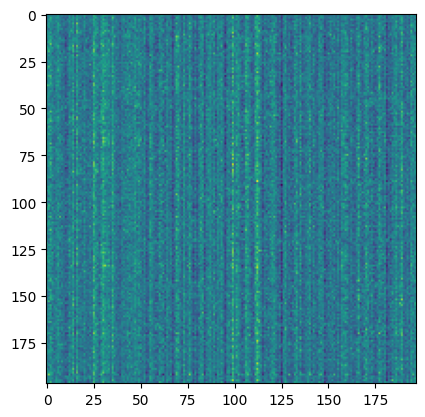

In [170]:
# plot imshow attns
plt.imshow(attns[0][0][0])